<a href="https://colab.research.google.com/github/techn-0/Digital_Imaging/blob/main/brightness_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 밝기 증강 (Brightness Augmentation) 프로젝트
## Albumentations + OpenCV를 활용한 밝기 조정

**목표**: 원본 이미지를 1000장으로 밝기 증강
- 증강 방법: 밝기 조정 (Brightness Adjustment)
- 증강 단계: 1000단계의 밝기 레벨

**사용 라이브러리**:
- Albumentations: 고성능 이미지 증강
- OpenCV: 기본 이미지 처리 및 알고리즘 원리

## 1. 라이브러리 설치 및 임포트

In [3]:
# 필요한 라이브러리 설치
!pip install albumentations opencv-python-headless matplotlib numpy pillow

In [1]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from google.colab import files
from PIL import Image
import zipfile
from tqdm import tqdm

print(f"Albumentations 버전: {A.__version__}")
print(f"OpenCV 버전: {cv2.__version__}")

Albumentations 버전: 2.0.8
OpenCV 버전: 4.12.0


## 2. 디렉토리 설정 및 이미지 업로드

In [4]:
# 디렉토리 생성
os.makedirs('original_images', exist_ok=True)
os.makedirs('brightness_augmented', exist_ok=True)
os.makedirs('brightness_results', exist_ok=True)

print("디렉토리 생성 완료")
print("- original_images: 원본 이미지 저장")
print("- brightness_augmented: 밝기 증강된 이미지 저장")
print("- brightness_results: 분석 결과 저장")

디렉토리 생성 완료
- original_images: 원본 이미지 저장
- brightness_augmented: 밝기 증강된 이미지 저장
- brightness_results: 분석 결과 저장


In [5]:
# 이미지 업로드
print("원본 이미지를 업로드해주세요...")
uploaded = files.upload()

# 업로드된 파일을 original_images 폴더로 이동
for filename in uploaded.keys():
    os.rename(filename, f'original_images/{filename}')
    print(f"✓ {filename} 저장 완료")

# 원본 이미지 목록 확인
original_images = list(Path('original_images').glob('*'))
original_images = [str(img) for img in original_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]

print(f"\n총 {len(original_images)}개의 원본 이미지가 준비되었습니다.")

원본 이미지를 업로드해주세요...


Saving cafe.jpg to cafe.jpg
Saving gameBoy.jpg to gameBoy.jpg
✓ cafe.jpg 저장 완료
✓ gameBoy.jpg 저장 완료

총 2개의 원본 이미지가 준비되었습니다.


## 3. 밝기 증강 파라미터 설정

### 목표: 1000장 생성
- 밝기 조정: 1000단계
- 범위: 0.1 ~ 2.0 배율 (매우 어두움 ~ 매우 밝음)
- 간격: 0.0019씩 증가 (1000단계)

In [6]:
# 밝기 증강 파라미터 정의
BRIGHTNESS_LEVELS = np.linspace(0.1, 2.0, 1000)  # 1000단계
TARGET_COUNT = 1000

print(f"밝기 조정 단계: {len(BRIGHTNESS_LEVELS)}개")
print(f"밝기 범위: {BRIGHTNESS_LEVELS[0]:.2f} ~ {BRIGHTNESS_LEVELS[-1]:.2f}")
print(f"밝기 간격: {BRIGHTNESS_LEVELS[1] - BRIGHTNESS_LEVELS[0]:.4f}")
print(f"\n총 생성될 이미지: {len(BRIGHTNESS_LEVELS)}장")

# 샘플 밝기 값 출력
print(f"\n[샘플 밝기 값]")
print(f"  매우 어두움: {BRIGHTNESS_LEVELS[0]:.2f}")
print(f"  어두움: {BRIGHTNESS_LEVELS[249]:.2f}")
print(f"  보통: {BRIGHTNESS_LEVELS[499]:.2f}")
print(f"  밝음: {BRIGHTNESS_LEVELS[749]:.2f}")
print(f"  매우 밝음: {BRIGHTNESS_LEVELS[999]:.2f}")

밝기 조정 단계: 1000개
밝기 범위: 0.10 ~ 2.00
밝기 간격: 0.0019

총 생성될 이미지: 1000장

[샘플 밝기 값]
  매우 어두움: 0.10
  어두움: 0.57
  보통: 1.05
  밝음: 1.52
  매우 밝음: 2.00


## 4. 밝기 조정 알고리즘

### 수학적 원리

밝기 조정은 각 픽셀의 값에 스케일 팩터(α)를 곱하여 수행됩니다:

$$I_{out}(x, y) = \alpha \times I_{in}(x, y)$$

여기서:
- $I_{in}(x, y)$: 입력 이미지의 (x, y) 위치 픽셀 값
- $I_{out}(x, y)$: 출력 이미지의 (x, y) 위치 픽셀 값
- $\alpha$: 밝기 배율 (0.1 ~ 2.0)

### 구현 방법
1. **Albumentations**: RandomBrightnessContrast 사용
2. **OpenCV**: convertScaleAbs 함수 사용

In [7]:
def augment_brightness_albumentations(image, brightness_factor):
    """
    Albumentations를 사용한 밝기 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        brightness_factor: 밝기 배율 (0.1~2.0)

    Returns:
        augmented_image: 밝기가 조정된 이미지
    """
    # Albumentations transform 정의
    # brightness_limit: -1.0은 완전히 어두움, +1.0은 2배 밝음
    transform = A.Compose([
        A.RandomBrightnessContrast(
            brightness_limit=(brightness_factor - 1.0, brightness_factor - 1.0),
            contrast_limit=(0, 0),  # 대비는 변경하지 않음
            p=1.0
        ),
    ])

    # 증강 적용
    augmented = transform(image=image)
    return augmented['image']


def augment_brightness_opencv(image, brightness_factor):
    """
    OpenCV를 사용한 밝기 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        brightness_factor: 밝기 배율

    Returns:
        augmented_image: 밝기가 조정된 이미지
    """
    # OpenCV의 convertScaleAbs 함수 사용
    # 공식: output = saturate_cast<uchar>(alpha * input + beta)
    # alpha: 밝기 배율, beta: 오프셋 (여기서는 0)
    brightened = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

    return brightened

print("✓ 밝기 증강 함수 정의 완료")

✓ 밝기 증강 함수 정의 완료


## 5. 알고리즘 비교 및 샘플 생성

/tmp/ipython-input-3339823020.py:36: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3339823020.py:36: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3339823020.py:36: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3339823020.py:36: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3339823020.py:36: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3339823020.py:36: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3339823020.py:37: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.savefig('brig

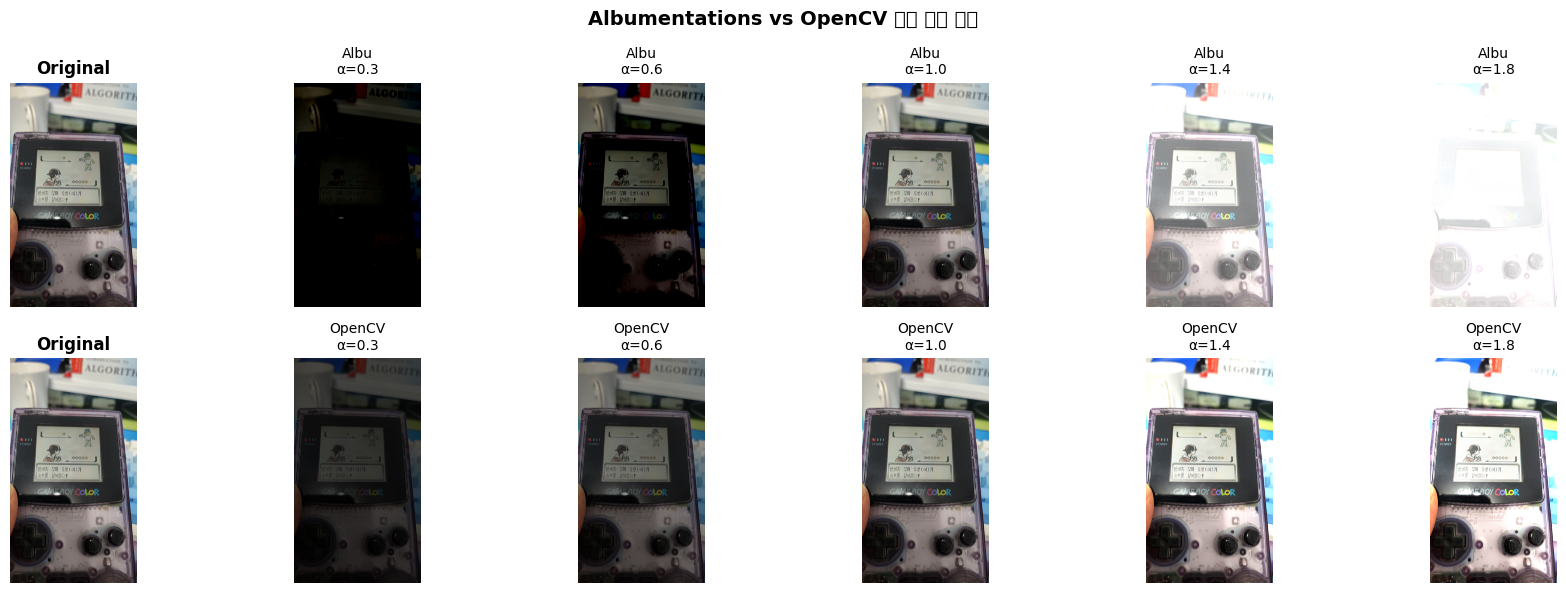

✓ 알고리즘 비교 이미지 저장: brightness_results/algorithm_comparison.png


In [8]:
# 첫 번째 원본 이미지로 샘플 생성
if len(original_images) > 0:
    sample_image_path = original_images[0]
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # 5가지 다른 밝기 레벨로 테스트
    test_brightness_levels = [0.3, 0.6, 1.0, 1.4, 1.8]

    # Albumentations 결과
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    # 첫 번째 행: Albumentations
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    for idx, brightness in enumerate(test_brightness_levels, 1):
        aug_img = augment_brightness_albumentations(sample_image, brightness)
        axes[0, idx].imshow(aug_img)
        axes[0, idx].set_title(f'Albu\nα={brightness:.1f}', fontsize=10)
        axes[0, idx].axis('off')

    # 두 번째 행: OpenCV
    axes[1, 0].imshow(sample_image)
    axes[1, 0].set_title('Original', fontweight='bold')
    axes[1, 0].axis('off')

    for idx, brightness in enumerate(test_brightness_levels, 1):
        aug_img = augment_brightness_opencv(sample_image, brightness)
        axes[1, idx].imshow(aug_img)
        axes[1, idx].set_title(f'OpenCV\nα={brightness:.1f}', fontsize=10)
        axes[1, idx].axis('off')

    plt.suptitle('Albumentations vs OpenCV 밝기 조정 비교', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('brightness_results/algorithm_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 알고리즘 비교 이미지 저장: brightness_results/algorithm_comparison.png")
else:
    print("⚠ 원본 이미지를 먼저 업로드해주세요.")

## 6. 밝기 단계별 샘플 시각화

/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-242885557.py:16: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/

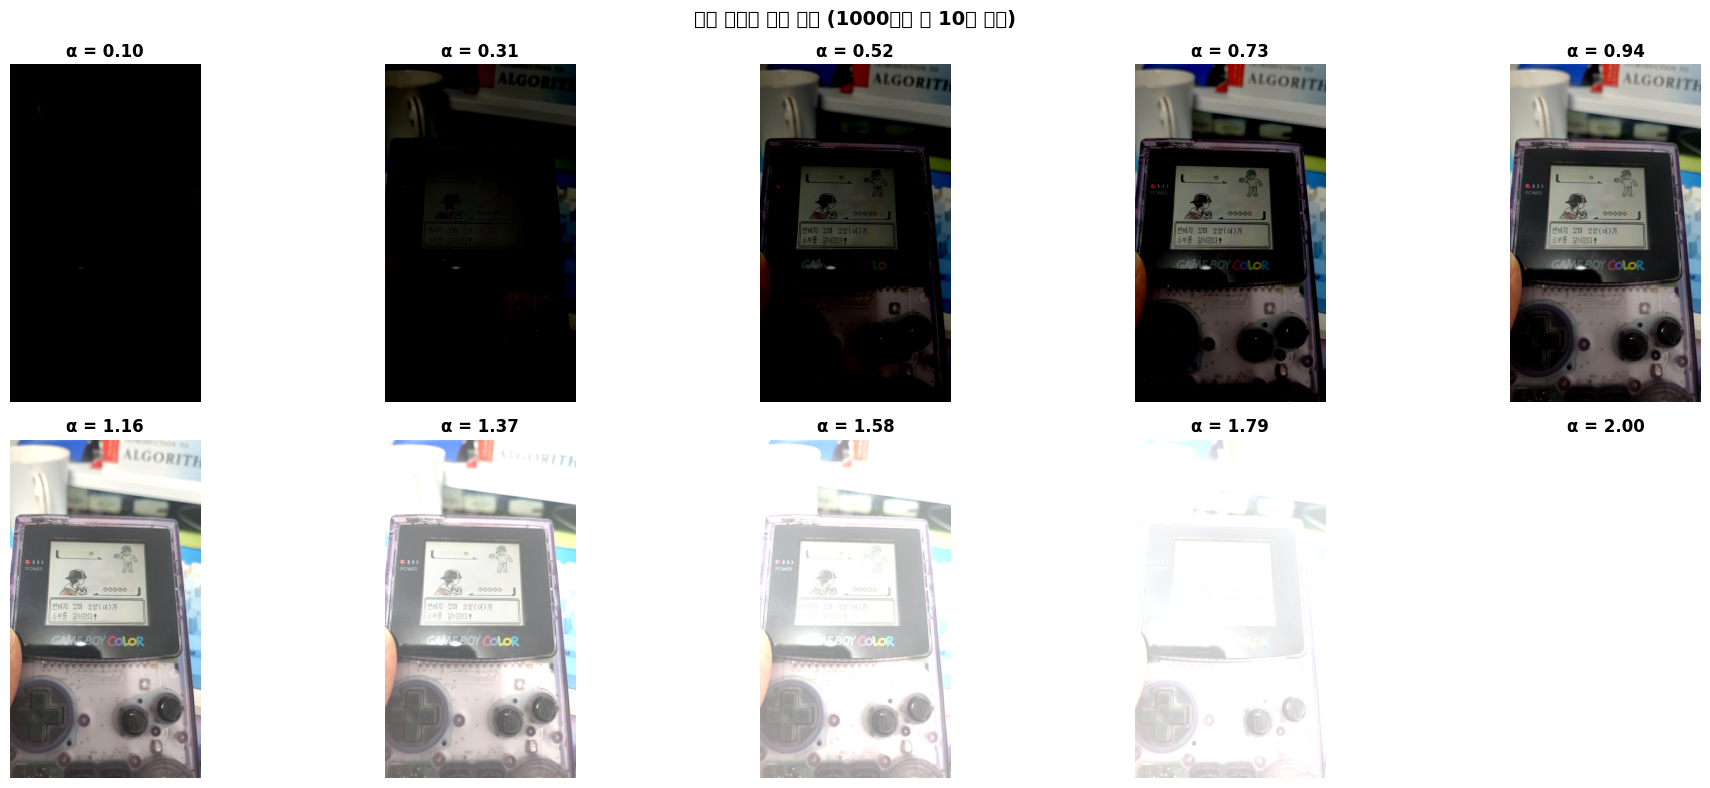

✓ 밝기 샘플 이미지 저장: brightness_results/brightness_samples.png


In [9]:
# 1000단계 중 대표적인 10단계 선택
if len(original_images) > 0:
    sample_indices = [0, 111, 222, 333, 444, 555, 666, 777, 888, 999]
    sample_brightnesses = BRIGHTNESS_LEVELS[sample_indices]

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for idx, brightness in enumerate(sample_brightnesses):
        aug_img = augment_brightness_albumentations(sample_image, brightness)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(f'α = {brightness:.2f}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('밝기 단계별 증강 결과 (1000단계 중 10개 샘플)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('brightness_results/brightness_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 밝기 샘플 이미지 저장: brightness_results/brightness_samples.png")

## 7. 전체 이미지 밝기 증강 수행 (1000장 생성)

In [10]:
def perform_brightness_augmentation(image_paths, output_dir, method='albumentations'):
    """
    전체 이미지 밝기 증강 수행

    Args:
        image_paths: 원본 이미지 경로 리스트
        output_dir: 출력 디렉토리
        method: 'albumentations' 또는 'opencv'
    """
    augment_func = augment_brightness_albumentations if method == 'albumentations' else augment_brightness_opencv

    total_augmentations = 0
    images_per_original = len(BRIGHTNESS_LEVELS)

    print(f"\n{'='*70}")
    print(f"밝기 증강 시작: {method.upper()} 방식")
    print(f"원본 이미지: {len(image_paths)}개")
    print(f"이미지당 생성 개수: {images_per_original}개")
    print(f"예상 총 생성 개수: {len(image_paths) * images_per_original}개")
    print(f"{'='*70}\n")

    for img_idx, img_path in enumerate(image_paths):
        # 이미지 로드
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        img_name = Path(img_path).stem

        print(f"[{img_idx+1}/{len(image_paths)}] 처리 중: {img_name}")

        # 모든 밝기 레벨에 대해 증강
        with tqdm(total=images_per_original, desc=f"  밝기 증강 진행") as pbar:
            for brightness_idx, brightness in enumerate(BRIGHTNESS_LEVELS):
                # 증강 수행
                augmented = augment_func(image, brightness)

                # 파일명 생성: 원본이름_brightness_인덱스.jpg
                output_filename = f"{img_name}_bright_{brightness_idx:04d}_alpha{brightness:.3f}.jpg"
                output_path = os.path.join(output_dir, output_filename)

                # 저장 (RGB -> BGR 변환)
                cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

                total_augmentations += 1
                pbar.update(1)

        print(f"  ✓ {img_name}: {images_per_original}개 생성 완료\n")

    print(f"\n{'='*70}")
    print(f"밝기 증강 완료!")
    print(f"총 생성된 이미지: {total_augmentations}개")
    print(f"저장 위치: {output_dir}")
    print(f"{'='*70}\n")

    return total_augmentations

In [11]:
# Albumentations로 밝기 증강 수행
total_count = perform_brightness_augmentation(
    original_images,
    'brightness_augmented',
    method='albumentations'
)


밝기 증강 시작: ALBUMENTATIONS 방식
원본 이미지: 2개
이미지당 생성 개수: 1000개
예상 총 생성 개수: 2000개

[1/2] 처리 중: gameBoy


  밝기 증강 진행: 100%|██████████| 1000/1000 [01:11<00:00, 13.95it/s]


  ✓ gameBoy: 1000개 생성 완료

[2/2] 처리 중: cafe


  밝기 증강 진행: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]

  ✓ cafe: 1000개 생성 완료


밝기 증강 완료!
총 생성된 이미지: 2000개
저장 위치: brightness_augmented



## 8. 증강 결과 분석 및 통계

총 증강된 이미지 개수: 2000개
목표 달성: ✓ 성공


/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2240852814.py:40: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tm

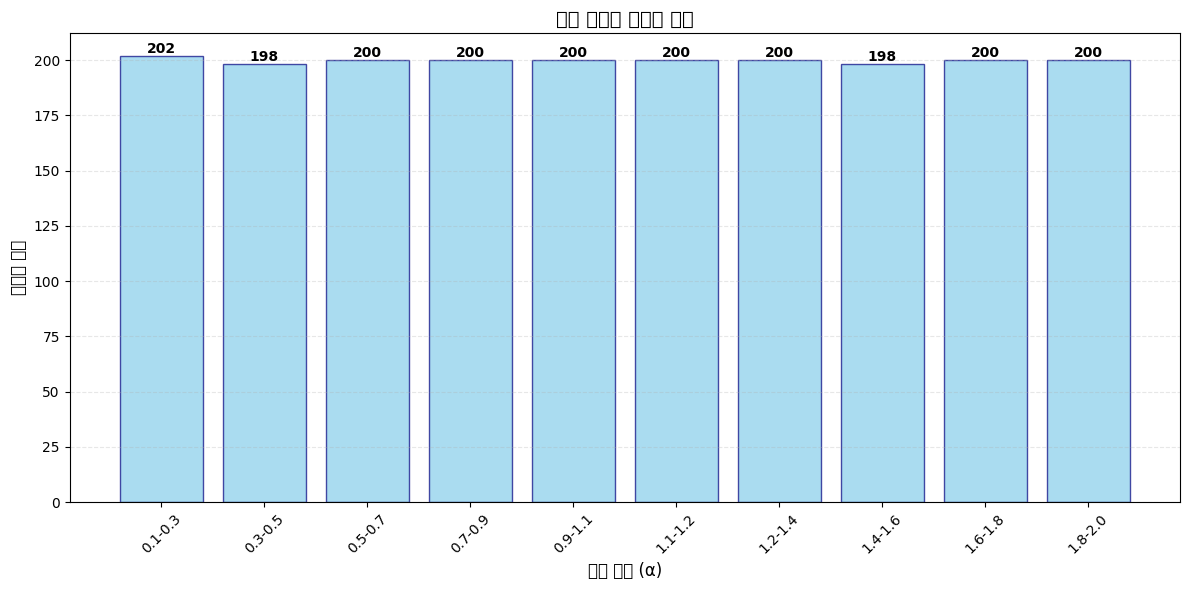

✓ 밝기 분포 그래프 저장: brightness_results/brightness_distribution.png


In [12]:
# 생성된 이미지 개수 확인
augmented_files = list(Path('brightness_augmented').glob('*.jpg'))
print(f"총 증강된 이미지 개수: {len(augmented_files)}개")
print(f"목표 달성: {'✓ 성공' if len(augmented_files) >= 1000 else '✗ 미달성'}")

# 밝기 분포 분석
brightness_distribution = np.zeros(10)  # 10개 구간으로 나눔
bins = np.linspace(0.1, 2.0, 11)

for file in augmented_files:
    # 파일명에서 알파 값 추출
    filename = file.stem
    if 'alpha' in filename:
        alpha_str = filename.split('alpha')[1]
        alpha_value = float(alpha_str)
        # 해당하는 구간 찾기
        for i in range(len(bins)-1):
            if bins[i] <= alpha_value < bins[i+1]:
                brightness_distribution[i] += 1
                break

# 분포 시각화
fig, ax = plt.subplots(figsize=(12, 6))

bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
bars = ax.bar(bin_labels, brightness_distribution, color='skyblue', edgecolor='navy', alpha=0.7)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('밝기 레벨별 이미지 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('밝기 배율 (α)', fontsize=12)
ax.set_ylabel('이미지 개수', fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('brightness_results/brightness_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 밝기 분포 그래프 저장: brightness_results/brightness_distribution.png")

## 9. 랜덤 샘플 시각화

/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3377849162.py:27: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_la

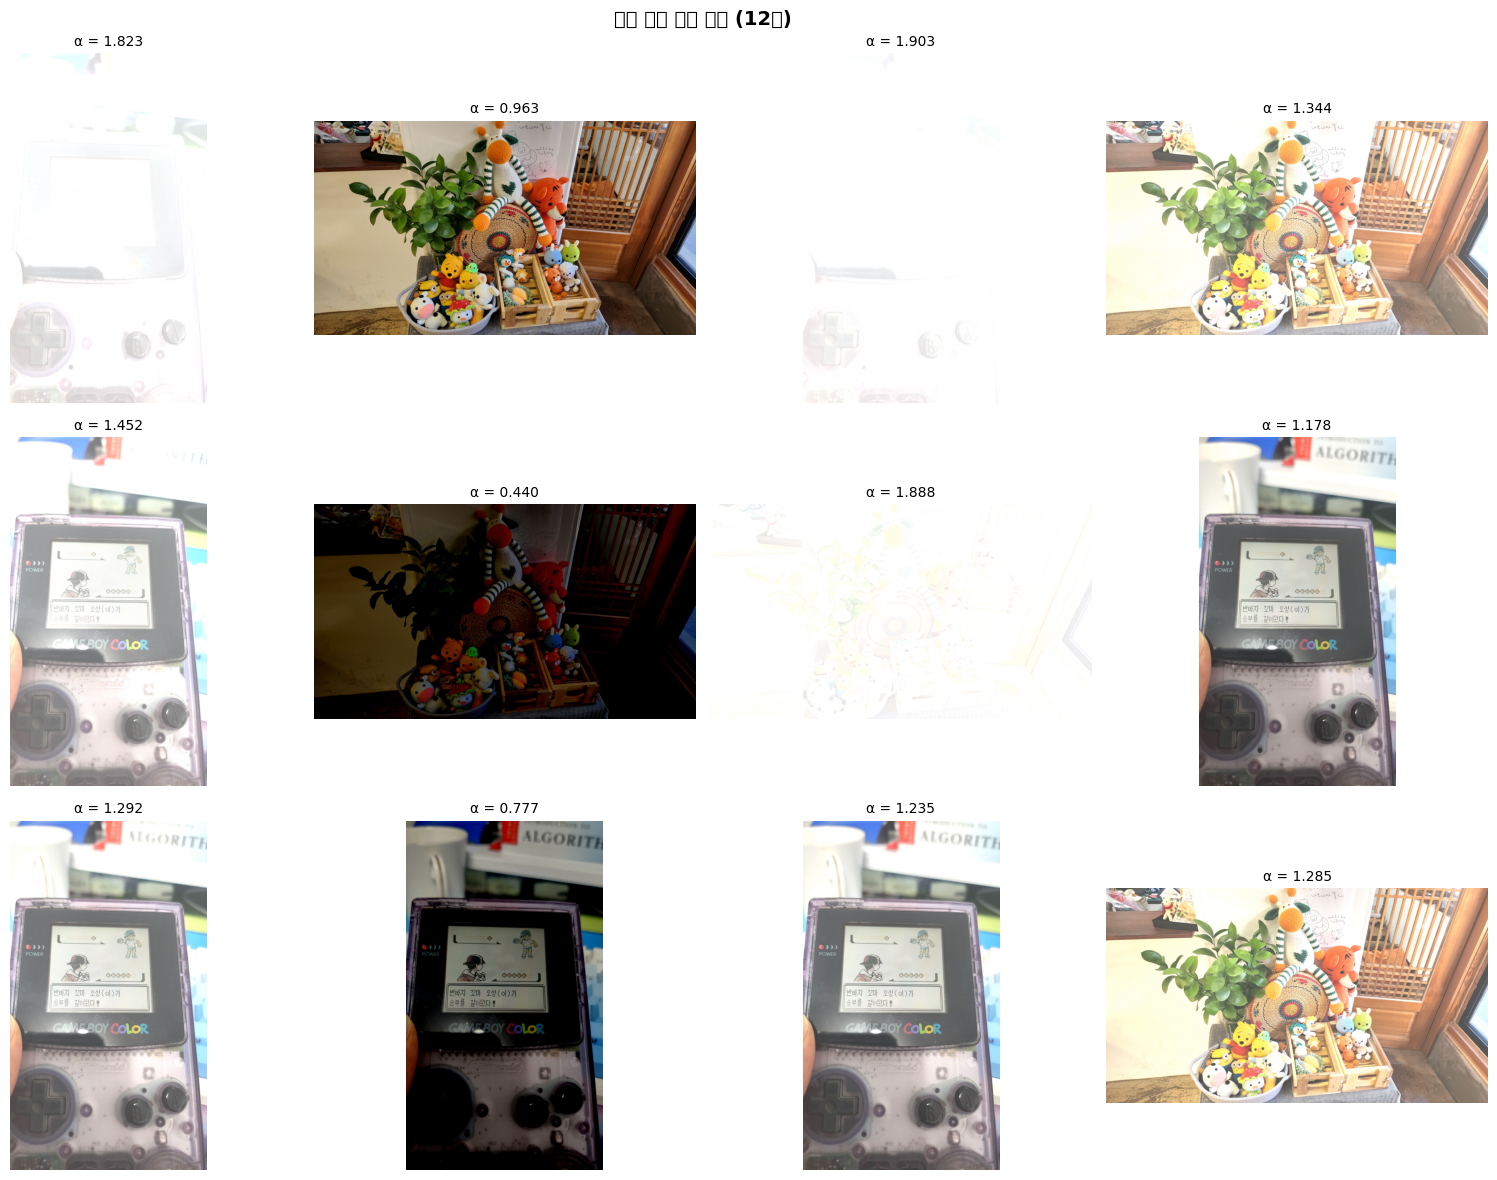

✓ 랜덤 샘플 이미지 저장: brightness_results/random_samples.png


In [13]:
# 랜덤 샘플 시각화
if len(augmented_files) > 0:
    import random
    sample_files = random.sample(augmented_files, min(12, len(augmented_files)))

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 파일명에서 알파 값 추출
        filename = img_path.stem
        if 'alpha' in filename:
            alpha_str = filename.split('alpha')[1]
            alpha_value = float(alpha_str)
            title = f'α = {alpha_value:.3f}'
        else:
            title = img_path.name

        axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=10)
        axes[idx].axis('off')

    plt.suptitle('밝기 증강 랜덤 샘플 (12개)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('brightness_results/random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 랜덤 샘플 이미지 저장: brightness_results/random_samples.png")

## 10. 픽셀 값 분포 분석

/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-339975311.py:38: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

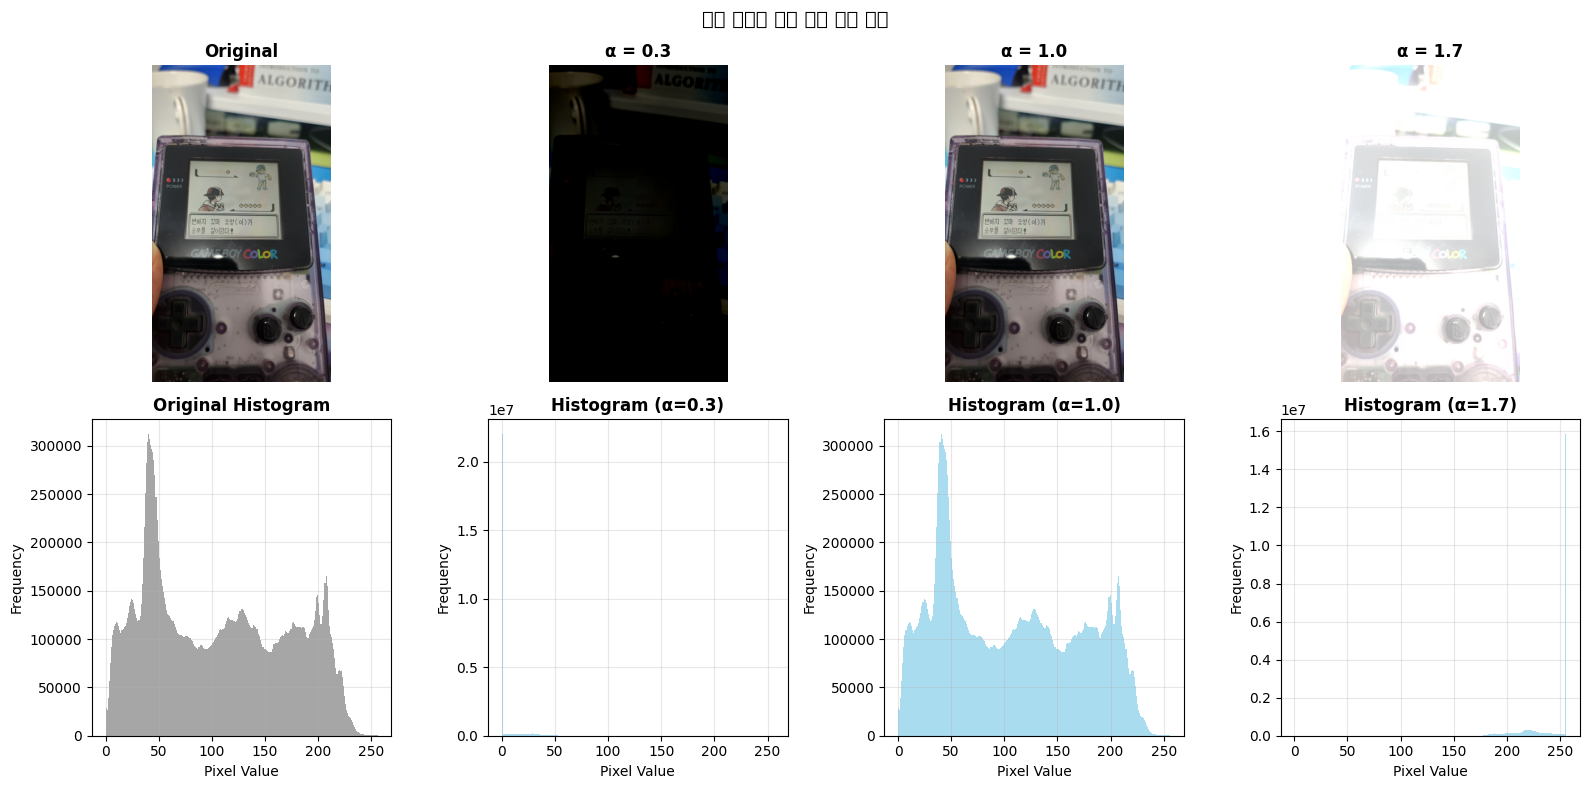

✓ 픽셀 분포 분석 저장: brightness_results/pixel_distribution.png


In [14]:
# 원본과 다양한 밝기 레벨의 픽셀 분포 비교
if len(original_images) > 0 and len(augmented_files) > 0:
    # 원본 이미지
    original = cv2.imread(original_images[0])
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # 대표 밝기 레벨 선택 (어두움, 보통, 밝음)
    test_alphas = [0.3, 1.0, 1.7]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # 원본
    axes[0, 0].imshow(original)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    axes[1, 0].hist(original.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.7)
    axes[1, 0].set_title('Original Histogram', fontweight='bold')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(alpha=0.3)

    # 각 밝기 레벨
    for idx, alpha in enumerate(test_alphas, 1):
        aug_img = augment_brightness_albumentations(original, alpha)

        axes[0, idx].imshow(aug_img)
        axes[0, idx].set_title(f'α = {alpha:.1f}', fontweight='bold')
        axes[0, idx].axis('off')

        axes[1, idx].hist(aug_img.ravel(), bins=256, range=(0, 256), color='skyblue', alpha=0.7)
        axes[1, idx].set_title(f'Histogram (α={alpha:.1f})', fontweight='bold')
        axes[1, idx].set_xlabel('Pixel Value')
        axes[1, idx].set_ylabel('Frequency')
        axes[1, idx].grid(alpha=0.3)

    plt.suptitle('밝기 증강에 따른 픽셀 분포 변화', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('brightness_results/pixel_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 픽셀 분포 분석 저장: brightness_results/pixel_distribution.png")

## 11. 결과 다운로드

In [15]:
# 증강된 이미지를 ZIP 파일로 압축
zip_filename = 'brightness_augmented_images.zip'

print("ZIP 파일 생성 중...")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in tqdm(augmented_files, desc="압축 진행"):
        zipf.write(file, file.name)

print(f"\n✓ ZIP 파일 생성 완료: {zip_filename}")
print(f"파일 크기: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# 다운로드
files.download(zip_filename)
print("\n다운로드가 시작되었습니다!")

ZIP 파일 생성 중...


압축 진행: 100%|██████████| 2000/2000 [03:47<00:00,  8.80it/s]


✓ ZIP 파일 생성 완료: brightness_augmented_images.zip
파일 크기: 3856.76 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


다운로드가 시작되었습니다!
